In [1]:
%load_ext autoreload
%autoreload 2

Data Preprocessing and Loading

In [2]:
from src.data.data import DataProcessor, TimeSeriesDataset, TimeSeriesDataLoader

# Preprocess data
data_processor = DataProcessor(start='2021-03-25 00:00:00', 
                               end='2021-03-31 00:00:00', 
                               verbose=True)
data_processor.prepare_data(filename='bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', 
                            exclude_columns_detrend=['SMA', 'RSI', 'MACD', 'log_ret', 'percent_ret'],
                            exclude_columns_scale=[''])

# Create dataloaders
train_loader, val_loader, test_loader = data_processor.create_dataloaders(window=60, 
                                                                          batch_size=128,
                                                                          exclude_input_columns=['percent_ret'])

data_processor.databundle.train.head()

Data loaded --------- data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv
Using data from 2021-03-25 00:00:00 to 2021-03-31 00:00:00 with 8640 rows and 12 columns


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,SMA,RSI,MACD,log_ret,percent_ret
Timestamp,,,,,,,,,,,,
2021-03-25 00:00:00,0.729207,0.733756,0.725159,0.750210,0.213251,0.219680,0.722782,0.327139,0.330301,0.440877,0.598433,0.596927
2021-03-25 00:01:00,0.731894,0.706903,0.691850,0.706159,0.120969,0.124426,0.699842,0.321779,0.254149,0.408615,0.275977,0.274726
2021-03-25 00:02:00,0.704679,0.680774,0.681653,0.675087,0.011959,0.012273,0.674946,0.314557,0.209386,0.369303,0.343152,0.341740
2021-03-25 00:03:00,0.665849,0.656457,0.647186,0.682978,0.121361,0.124407,0.648567,0.308074,0.235800,0.345230,0.546499,0.544946
2021-03-25 00:04:00,0.671666,0.724024,0.684280,0.752804,0.124708,0.128321,0.704886,0.303359,0.426979,0.365662,0.869006,0.868292


Initialize model

In [3]:
from torchinfo import summary
from src.model.lstm import LSTM

# Input dimension
sample_batch = next(iter(train_loader))
sample_x, _ = sample_batch
input_dim = sample_x.shape[2] 

# Initialize model
model = LSTM(input_dim=input_dim, 
             hidden_dim=256, 
             output_dim=1, 
             num_layers=2, 
             fc_hidden_dim=256,
             use_hn=False, 
             dropout=0.5,
             maintain_state=True)

# Print model summary
print(summary(model, input_data=sample_x))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [128, 1]                  --
├─LSTM: 1-1                              [128, 60, 256]            801,792
├─Sequential: 1-2                        [128, 1]                  --
│    └─Linear: 2-1                       [128, 256]                65,792
│    └─ReLU: 2-2                         [128, 256]                --
│    └─Linear: 2-3                       [128, 1]                  257
Total params: 867,841
Trainable params: 867,841
Non-trainable params: 0
Total mult-adds (G): 6.17
Input size (MB): 0.34
Forward/backward pass size (MB): 15.99
Params size (MB): 3.47
Estimated Total Size (MB): 19.80


Train model

C:\Users\harri\OneDrive\Documents\Projects\deep-trading-algorithm\src\train\trainer.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Using Device: cuda
Training --------- Model: LSTM


Batch [47/47]	: 100%|██████████| 100/100 [08:02<00:00,  4.82s/it, Batch Loss: 0.002981 (0.006908)	Loss: 0.006918 (0.00717)	Val Loss: 0.003516 (0.004526)]


Tensorboard closed successfully.


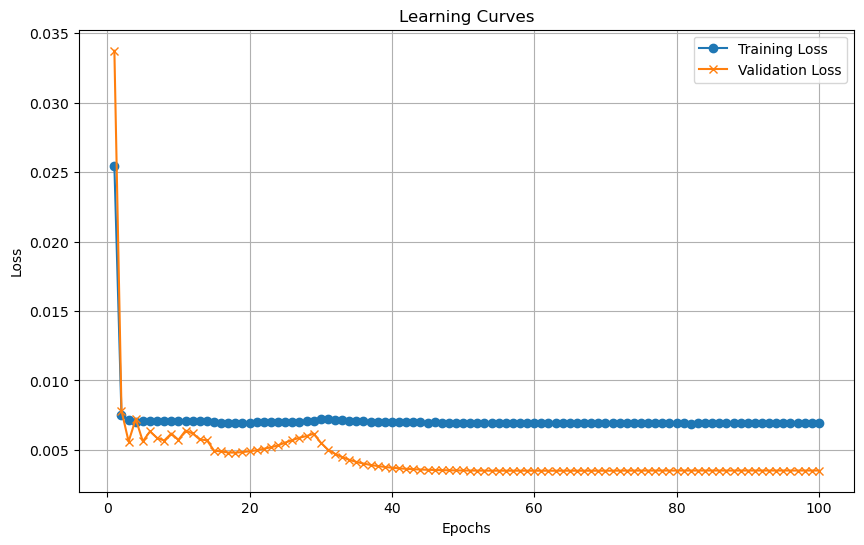

In [4]:
from src.train.trainer import Trainer
from src.train.utils import plot_learning_curves
from src.utils import google_colab_handler

running_in_colab, use_TPU, path, device = google_colab_handler(use_TPU=False, verbose=True)

trainer = Trainer(model=model,
                  device=device,
                  verbose=True,
                  running_in_colab=running_in_colab,
                  use_TPU=use_TPU,
                  use_tensorboard=True)

trainer.train(train_loader=train_loader,
                    val_loader=val_loader,
                    epochs=100,
                    lr=0.001,
                    no_change_patience=100,
                    overfit_patience=100,
                    warmup=10,
                    save_best=True)

plot_learning_curves(trainer.state.train_losses, trainer.state.val_losses)